# Task: Testing changes related to the introduction of an improved recommendation system #

## hypotheses: there will be at least a 10% increase in conversion rate ##
***That means there is a significant difference between the proportions of the groups, movemant through the event funnel is significantly different between the groups.(rejection of null hypotesis)***

### Technical description ##

- Test name: `recommender_system_test`
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.
- Expected number of test participants: 6000


### Data description ###
Structure of `ab_project_marketing_events_us.csv`:

- `name` — the name of the marketing event
- `regions` — regions where the ad campaign will be held
- `start_dt` — campaign start date
- `finish_dt` — campaign end date

Structure of `final_ab_new_users_upd.csv`:

- `user_id`
- `first_date` — sign-up date
- `region`
- `device` — device used to sign up

Structure of `final_ab_events_upd.csv`:

- `user_id`
- `event_dt` — event date and time
- `event_name` — event type name
- `details` — additional data on the event (for instance, the order total in USD for `purchase` events)

Structure of `final_ab_participants_upd.csv`:

- `user_id`
- `ab_test` — test name
- `group` — the test group the user belonged to

## mandatory stages of analysis ##

### Step 1. Download the data and neaded libraries/tools

In [2]:
!python -m pip install --upgrade pip
!python -m pip install sidetable -U
!python -m pip install -U seaborn 

     |████████████████████████████████| 2.1 MB 1.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [3]:
# Loading all the libraries

import pandas as pd
import numpy as np
from scipy import stats as st
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable as stb
import plotly.express as px
import plotly.graph_objects as go
import math 
from functools import reduce
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_colwidth = 200  

In [4]:
# Load the data files into a DataFrame

try: 
    marketing_events = pd.read_csv('ab_project_marketing_events_us.csv', parse_dates=['start_dt', 'finish_dt'])         
    
except:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', parse_dates=['start_dt', 'finish_dt'])
   

 
display(marketing_events.head(), len(marketing_events))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


14

In [5]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


***ab_project_marketing_events_us.csv — the calendar of marketing events for 2020***

Structure of `ab_project_marketing_events_us.csv`:

- `name` — the name of the marketing event
- `regions` — regions where the ad campaign will be held
- `start_dt` — campaign start date
- `finish_dt` — campaign end date

In [6]:
try: 
    users = pd.read_csv('final_ab_new_users_upd_us.csv', parse_dates=['first_date'])         
    
except:
    users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', parse_dates=['first_date'])
   

 
display(users.head(), len(users))

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


58703

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


***final_ab_new_users_upd.csv — all users who signed up in the online store from December 7 to 21, 2020***

Structure of `final_ab_new_users_upd.csv`:

- `user_id`
- `first_date` — sign-up date
- `region`
- `device` — device used to sign up

In [8]:
try: 
    user_events = pd.read_csv('final_ab_events_upd_us.csv', parse_dates=['event_dt'])        
    
except:
    user_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv', parse_dates=['event_dt'])
   

 
display(user_events.head(), len(user_events))

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990


423761

In [9]:
user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


***final_ab_events_upd.csv — all events of the new users within the period from December 7, 2020 to January 1, 2021***

Structure of `final_ab_events_upd.csv`:

- `user_id`
- `event_dt` — event date and time
- `event_name` — event type name
- `details` — additional data on the event (for instance, the order total in USD for `purchase` events)

In [10]:
try: 
    participants = pd.read_csv('final_ab_participants_upd_us.csv')        
    
except:
    participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
   

 
display(participants.head(), len(participants))

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


14525

In [11]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


***final_ab_participants_upd.csv — table containing test participants***

Structure of `final_ab_participants_upd.csv`:

- `user_id`
- `ab_test` — test name
- `group` — the test group the user belonged to

### Step 2. Exploratory data analysis (EDA)

#### Study missing valuesand deal with missing values (remove or replace)

In [12]:
marketing_events.stb.missing(style=True)

,missing,total,percent
name,0,14,0.00%
regions,0,14,0.00%
start_dt,0,14,0.00%
finish_dt,0,14,0.00%


No misssing values.

In [13]:
users.stb.missing(style=True)

,missing,total,percent
user_id,0,"58,703",0.00%
first_date,0,"58,703",0.00%
region,0,"58,703",0.00%
device,0,"58,703",0.00%


No misssing values.

In [14]:
user_events.stb.missing(style=True)

,missing,total,percent
details,"363,447","423,761",85.77%
user_id,0,"423,761",0.00%
event_dt,0,"423,761",0.00%
event_name,0,"423,761",0.00%


About 86% of rows have missing values in the details column, the column containing the additional data on the event for example the order sum in purcherse events. 

In [15]:
user_events.groupby('event_name').median()

,details
event_name,
login,NaN
product_cart,NaN
product_page,NaN
purchase,4.990


The rows with missing details column are of the events other then purchase, thus having no purchase details or purchase sum. 

Which makes sense.  

In [16]:
participants.stb.missing(style=True)

,missing,total,percent
user_id,0,"14,525",0.00%
group,0,"14,525",0.00%
ab_test,0,"14,525",0.00%


No misssing values.

#### Study type correspondence and convert data types

In [17]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [19]:
user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [20]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


All data types match the contents of the columns.

#### Study duplicate values and remove duplicates

In [21]:
marketing_events.duplicated().sum()

0

In [22]:
users.duplicated().sum()

0

In [23]:
user_events.duplicated().sum()

0

In [24]:
participants.duplicated().sum()

0

No duplicate​s found.

#### Make sure that there are no users assigned to multiple groups, if such users are present remove data from the data used in A/B testing

In [25]:
print(participants.head())

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test


In [26]:
orders_a = participants.query('group == "A"')
orders_b = participants.query('group == "B"')

dual = orders_a[orders_a.user_id.isin(orders_b.user_id)]
dual.count()

user_id    441
group      441
ab_test    441
dtype: int64

In [27]:
dual.user_id.count()/participants.user_id.count()

0.030361445783132532

only 3% of data are insignificant and tus can be droped. 

In [28]:
participants = participants[~participants.user_id.isin(dual.user_id)]

orders_a = participants.query('group == "A"')
orders_b = participants.query('group == "B"')

dual = orders_a[orders_a.user_id.isin(orders_b.user_id)]
dual.count()

user_id    0
group      0
ab_test    0
dtype: int64

 No more users assigned to multiple groups, in the test.

### Test name: recommender_system_test is the test used and users from the EU are the ones being tested

#### Filter by test (recommender_system_test)

In [76]:
par = participants.query('ab_test == "recommender_system_test"')
display(par.head(), len(par))

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


3234

#### Filter by region (EU)

In [77]:
users1 = users.query('region == "EU"')
display(users1.head(), len(users1))

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android


43396

## Calculate metrics and make charts

### check for anomalies and outliers

The only place where anomalies and outliers can exist is the details column of user_events, because all other data is not numerical.

In [29]:
purcheses = user_events.query('event_name == "purchase"')
np.percentile(purcheses['details'], [90, 95, 99])

array([ 99.99,  99.99, 499.99])

### Study conversion at different funnel stages

In [78]:
subjects = par.merge(users1, on=['user_id'], how='inner')
subjects.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac


In [82]:
merged1 = subjects.merge(user_events,on=['user_id'],how='inner')
merged1.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.990
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN


In [83]:
merged1.groupby(['event_name'])['user_id'].count().sort_values(ascending=False)

event_name
login           9014
product_page    5578
purchase        2728
product_cart    2663
Name: user_id, dtype: int64

In [84]:
merged1.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)/merged1.user_id.nunique()

event_name
login          1.000
product_page   0.627
purchase       0.314
product_cart   0.296
Name: user_id, dtype: float64

- All users entred via login page

- 62.7% of them used the product page

- 29.6% of them used the product cart 

- 31.4% of them made a purchase

In [85]:
sort_log = merged1.sort_values(by=['user_id','event_dt'])
sort_log.sample(10)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
9791,313EDFD0B02DB143,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-14 06:30:35,product_page,NaN
17932,18926530B5F5BCDD,A,recommender_system_test,2020-12-20,EU,Android,2020-12-20 06:23:22,product_cart,NaN
6064,983E7021DDC7E0FA,A,recommender_system_test,2020-12-21,EU,Mac,2020-12-21 15:38:02,product_page,NaN
6151,0E450AE02863F478,A,recommender_system_test,2020-12-17,EU,Android,2020-12-21 13:17:45,product_cart,NaN
18997,E18160F4BCA5344E,A,recommender_system_test,2020-12-19,EU,iPhone,2020-12-20 05:31:06,login,NaN
7646,C6CFFE9F0D5BC0BF,B,recommender_system_test,2020-12-09,EU,Mac,2020-12-09 23:15:30,product_cart,NaN
4938,568C35FDE36F7C26,A,recommender_system_test,2020-12-15,EU,Android,2020-12-15 05:11:29,purchase,9.990
1187,B8BA68A40CCA2F92,A,recommender_system_test,2020-12-17,EU,Android,2020-12-17 05:17:42,login,NaN
18227,DABC08CC80316871,A,recommender_system_test,2020-12-10,EU,PC,2020-12-29 20:09:54,login,NaN
16074,A244B2AA7F792F5B,B,recommender_system_test,2020-12-07,EU,PC,2020-12-09 15:24:54,product_page,NaN


In [86]:
def sequence(user):
    sorted_user=sort_log[sort_log['user_id']==user].sort_values(by=['user_id','event_dt'])
    return sorted_user['event_name'].drop_duplicates().to_list()

In [87]:
sequence_empty=[]
for i in sort_log.user_id.unique():
    sequence_empty.append([i,sequence(i)])

In [88]:
path_data=pd.DataFrame(sequence_empty,columns=['user','path'])
path_data

,user,path
0,001064FEAAB631A1,"[login, product_page]"
1,0010A1C096941592,"[purchase, product_page, login]"
2,00341D8401F0F665,[login]
3,003DF44D7589BBD4,"[product_cart, product_page, login]"
4,00505E15A9D81546,[login]
...,...,...
3035,FF5A1CD38F5DD996,"[product_page, login]"
3036,FF5B24BCE4387F86,"[purchase, login, product_page]"
3037,FF825C1D791989B5,"[product_cart, login]"
3038,FF8CF7057415EB29,"[product_page, login]"


In [89]:
path_data['path_s'] = path_data['path'].astype("string")
path_data['path_s'].value_counts()

['login']                                                592
['login', 'product_page']                                502
['product_page', 'login']                                392
['purchase', 'login', 'product_page']                    254
['purchase', 'login']                                    201
['purchase', 'product_page', 'login']                    195
['login', 'product_cart']                                131
['product_cart', 'login']                                100
['login', 'product_cart', 'product_page']                 96
['product_cart', 'product_page', 'login']                 91
['product_page', 'login', 'product_cart']                 72
['product_cart', 'login', 'product_page']                 64
['purchase', 'login', 'product_cart']                     61
['purchase', 'login', 'product_cart', 'product_page']     56
['purchase', 'product_cart', 'product_page', 'login']     51
['login', 'product_page', 'product_cart']                 45
['purchase', 'product_ca

In [90]:
funnel_by_groups=[]
for i in sort_log.group.unique():
    group=sort_log[sort_log.group==i].groupby(['event_name','group'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
    display(group)
    funnel_by_groups.append(group)
    

,event_name,group,user_id
0,login,B,760
2,product_page,B,431
3,purchase,B,221
1,product_cart,B,214


,event_name,group,user_id
0,login,A,2279
2,product_page,A,1476
3,purchase,A,734
1,product_cart,A,686


In [91]:
funnel_by_groups=pd.concat(funnel_by_groups)
funnel_by_groups

,event_name,group,user_id
0,login,B,760
2,product_page,B,431
3,purchase,B,221
1,product_cart,B,214
0,login,A,2279
2,product_page,A,1476
3,purchase,A,734
1,product_cart,A,686


In [92]:
fig=px.funnel(funnel_by_groups,x='user_id',y='event_name',color='group', title ="Event funnel by group")
fig.show()

Conclusions: 

- The funnels show logical flow from login page to product page, but as purchase and cart pages are about equal the flow seams strange.

- Judging by the path data (path_s), many users start at purchese page (probably by promotional link or other link), which partialy explins the abnormality mentioned before. 

### Is the number of events per user distributed equally in the samples?

In [93]:
sort_log.groupby(['group'])['user_id'].nunique()

group
A    2279
B     761
Name: user_id, dtype: int64

The groups are not disrebuted equaly.

In [94]:
sort_log.groupby(['event_name', 'group'])['user_id'].nunique().sort_values(ascending=False)

event_name    group
login         A        2279
product_page  A        1476
login         B         760
purchase      A         734
product_cart  A         686
product_page  B         431
purchase      B         221
product_cart  B         214
Name: user_id, dtype: int64

As can be seen in the funnel and the funnel_by_groups, the number of events per user is not distributed equally in the samples. 

In [95]:
gr_a = sort_log.query('group == "A"')
gr_b = sort_log.query('group == "B"')

gr_a.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)/gr_a.user_id.nunique()

event_name
login          1.000
product_page   0.648
purchase       0.322
product_cart   0.301
Name: user_id, dtype: float64

In [96]:
gr_b.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)/gr_b.user_id.nunique()

event_name
login          0.999
product_page   0.566
purchase       0.290
product_cart   0.281
Name: user_id, dtype: float64

The funnel flow in percents shows proportins are unequal. 

### How is the number of events distributed by days?

In [97]:
merged1['date'] = pd.DatetimeIndex(merged1['event_dt']).date
merged1.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.990,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,2020-12-07
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,2020-12-20


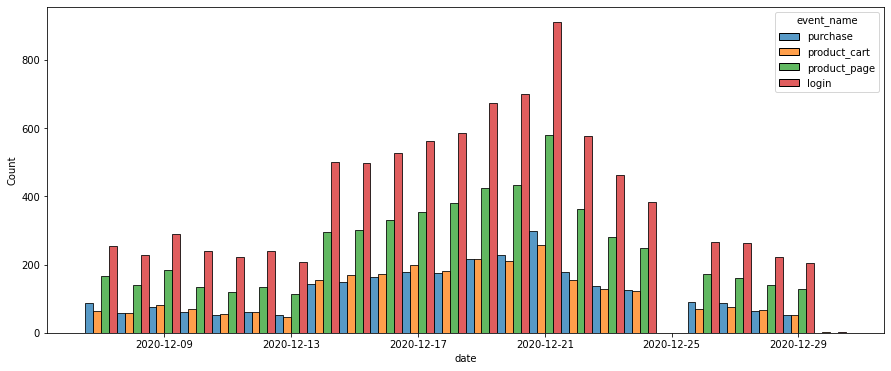

In [98]:
plt.rcParams["figure.figsize"] = (15,6)
fig, ax = plt.subplots()
sns.histplot(
            data=merged1, x='date', hue ='event_name', multiple='dodge',
            bins=70, ax=ax
    )
plt.show()

Conclusions: 

- Data after 25-12-2020 is a bit problematic because it was colected during Christmas&New Year Promo (2020-12-25 to 2021-01-03), but it shows no diferance from other data as the date when they stopped taking up new users is 2020-12-21.

- Cart and purchase stages are about equal most of the test.  

## A/B Test Analysis

The groups are not disrebuted equaly, but the proportions_ztest can be used.

### find out which test method should be applied in this case (or write a function that does that)

**specify H0, H1 and significance level**
 
 **H0:** π₁ = π₂, There is no significant difference between the proportions of the groups. This means movemant through current step of the event funnel is not significantly different between the groups.
 
 **H1:**  π₁ != π₂, There is a significant difference between the proportions of the groups. This means movemant through current step of the event funnel is significantly different between the groups.
 
 **significance level:** 0.05, The probability of making a type I error is equal to the significance level, α.
 A type II error is a false negative result. This means there is difference between the groups, but the test yielded a p-value  greater than α. You can't have an arbitrarily low probability of making a type I error and an arbitrarily low probability of making a type II error; there is a tradeoff between the two in any hypothesis test, by choosing a significance level of 1% or 5%, we can strike a good balance between the two.

In [99]:
def eve_flow(event):
    if event == "login":
        return "stage 1"
    if event == "product_page":
        return "stage 2"    
    if event == "product_cart":
        return "stage 3"   
    if event == "purchase":
        return "stage 4"       

In [100]:
sort_log['eve_n'] = sort_log['event_name'].apply(
    eve_flow
)
sort_log.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,eve_n
668,001064FEAAB631A1,B,recommender_system_test,2020-12-20,EU,Android,2020-12-20 14:43:27,login,NaN,stage 1
665,001064FEAAB631A1,B,recommender_system_test,2020-12-20,EU,Android,2020-12-20 14:43:28,product_page,NaN,stage 2
669,001064FEAAB631A1,B,recommender_system_test,2020-12-20,EU,Android,2020-12-21 03:19:15,login,NaN,stage 1
666,001064FEAAB631A1,B,recommender_system_test,2020-12-20,EU,Android,2020-12-21 03:19:17,product_page,NaN,stage 2
670,001064FEAAB631A1,B,recommender_system_test,2020-12-20,EU,Android,2020-12-26 15:55:17,login,NaN,stage 1


In [101]:
sort_log1 = sort_log.sort_values(by='eve_n')
sort_log1.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,eve_n
668,001064FEAAB631A1,B,recommender_system_test,2020-12-20,EU,Android,2020-12-20 14:43:27,login,NaN,stage 1
12074,B8EF6F0325A9979F,A,recommender_system_test,2020-12-20,EU,PC,2020-12-23 21:16:04,login,NaN,stage 1
7309,5CB4D86F5B780C81,A,recommender_system_test,2020-12-21,EU,Android,2020-12-21 08:49:13,login,NaN,stage 1
12073,B8EF6F0325A9979F,A,recommender_system_test,2020-12-20,EU,PC,2020-12-21 16:22:23,login,NaN,stage 1
7310,5CB4D86F5B780C81,A,recommender_system_test,2020-12-21,EU,Android,2020-12-22 16:55:20,login,NaN,stage 1


In [102]:
pivot=sort_log1.pivot_table(index='eve_n', columns='group',values='user_id',aggfunc='nunique').reset_index()
pivot

group,eve_n,A,B
0,stage 1,2279,760
1,stage 2,1476,431
2,stage 3,686,214
3,stage 4,734,221


In [103]:
def check_hypothesis(group1,group2,event,alpha=0.05):
    success1=pivot[pivot.eve_n==event][group1].iloc[0]
    success2=pivot[pivot.eve_n==event][group2].iloc[0]
    
    trials1=sort_log[sort_log.group==group1]['user_id'].nunique()
    trials2=sort_log[sort_log.group==group2]['user_id'].nunique()    
    

    stat, p_value = proportions_ztest([success1, success2], [trials1, trials2])
    print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

    if (p_value < alpha):
        print("Rejecting the null hypothesis for", event,"and groups", group1,group2)
    else:
        print("Failed to reject the null hypothesis for",event,"and groups", group1,group2)

In [104]:
def testing_average(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=st.shapiro(sample1)
    stat2, p2_norm=st.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=st.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=st.ttest_ind(sample1, sample2,equal_var=False)
            u_test = "t-test var not equal"
        else:
            statist,p_value=st.ttest_ind(sample1, sample2,equal_var=True) 
            u_test = "t-test var equal"
    else:
        statist,p_value=st.mannwhitneyu(sample1, sample2)
        u_test = "Mann–Whitney U"
    print(p_value)
    if p_value<alpha:
        print('Reject H0')
    else:
        print('Fail to Reject H0')
    print(u_test)

### Apply A/B test 

In [105]:
for i in pivot.eve_n.unique():
    check_hypothesis("A", "B", i, alpha=0.05)


z_stat: 1.731, p_value: 0.083
Failed to reject the null hypothesis for stage 1 and groups A B
z_stat: 4.016, p_value: 0.000
Rejecting the null hypothesis for stage 2 and groups A B
z_stat: 1.036, p_value: 0.300
Failed to reject the null hypothesis for stage 3 and groups A B
z_stat: 1.629, p_value: 0.103
Failed to reject the null hypothesis for stage 4 and groups A B


### Make conclusions based on A/B test and statistical difference between the proportions

Conclusions: 

- The A/B test showed no differance in the conversion rate in most funnel stages (Failed to reject the null hypothesis).

- The exeption is stage 2 (product_page entry), so users view prodacts at a diferrant rate but buy at about the same rate.

-  The expected 10% increase in conversion rate at each of the funnel stages, did not happen. 

## Project conclusions

### Overall conclusions (based on EDA stage, matrics and the A/B test results)

- The rows with missing details column are of the events other than purchase, thus having no purchase details or purchase sum, which makes sense.

- All data types match the contents of the columns, and no duplicates were found.

- Users assigned to multiple groups were 3% of users, and they were dropped. 

- Data belonging to the test (recommender_system_test), was only a small percent of the test data provided. The data also needed to be filtered by region.

- All users entered via login page, 62.7% of them used the product page, 29.6% of them used the product cart, 31.4% of them made a purchase.

- Judging by the path data (path_s), many users start at purchase page (probably by promotional link or promo-code) , which possibly explains the strange ratio between purchase and cart pages.

- The number of events per user is not distributed equally in the samples.

- Data after 25-12-2020 might be a bit problematic because it was collected during Christmas&New Year Promo (2020-12-25 to 2021-01-03), but it shows no difference from other data, possibly because the date when they stopped taking up new users is 2020-12-21.

- The A/B test showed no difference in the conversion rate in most funnel stages (Failed to reject the null hypothesis). With the exception of stage 2 (product_page entry), users view products at a different rate but buy at the about same rate.

-  The expected 10% increase in conversion rate at each of the funnel stages, did not happen.


### Basic recommendations (based on conclusions)

- Providing more accurate and specific data can posibly lead to clearer results.

- Conducting the test not during promo events can possibly lead to better results.

- While the expected 10% increase in conversion rate at each of the funnel stages, did not happen a change in the entry to product page did and judgging by 3.3 a change for the worse. The old recommendation system should probably stay as is.    